# Team 4 Machine Predictive Maintenance Classification

Contributors: Elan Wilkinson, Zack Robertson, Alden Caterio, Laxmi Sulakshana Rapolu


## Problem Statement

Companies that produce various types of machinery are aware that all of their products have a breaking point, and they are highly interested in understanding the causes. Having a clear understanding of why a machine breaks can be helpful in multiple ways. The company can create more robust machines which are less prone to failure, develop methods to maintain existing machines, and even predict when a machine may fail, extending its lifespan and saving the customer money and resources.

In this project, we examine a Predictive Maintenance Dataset which comprises of temperature readings, readings from and measurement data from the equipment, product quality variants, failure states, and failure types. Using the dataset, we will predict likely future failure and type. Multiple modeling approaches will be evaluated, with a particular emphasis on leveraging ensemble methods.

## Justification

This initiative is driven by the urgent need within the industry to improve machinery reliability and longevity. By understanding and predicting potential failures, we can not only design more robust equipment but also develop proactive maintenance strategies.

Through precise failure forecasts, predictive maintenance can notably prolong equipment longevity, offering significant financial and resource savings. It also promises heightened product standards, minimized operational interruptions, and increased efficiency.

Our investigation will delve into various modeling techniques, focusing on the power of ensemble methods to bolster prediction accuracy by merging multiple model advantages. Assessing these methods side by side will shed light on the most efficacious predictive maintenance strategies.

Ultimately, the success of this project could transform maintenance practices in machinery production, steering towards more durable, efficient, and economical operations.

In [205]:
# !pip install ucimlrepo pandas numpy matplotlib seaborn dataprep scikit-learn tensorflow imblearn xgboost
!pip install ucimlrepo dataprep tensorflow

In [206]:
# Import required libraries
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder, StandardScaler
from dataprep.eda import plot, plot_correlation, plot_missing, plot_diff, create_report
from dataprep.clean import *
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from scipy.stats import randint
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Clean up warnings and loggings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.INFO)

## Dataset
The Predictive Maintenance Dataset encompasses 10,000 data points, each with 10 distinct features.

Dataset URL: https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification

**Feature Variables**:
- Type : The product quality is categorized using the letters L, M, and H to represent low (50% of all products), medium (30%), and high (20%) quality variants, respectively. This system simplifies the classification of product standards across the range.
- air temperature [K] : The data was produced through a random walk process and subsequently adjusted to have a standard deviation of 2 Kelvin, centered around a mean temperature of 300 Kelvin.
- process temperature [K] : The process involves a random walk method, adjusted to a standard deviation of one Kelvin. This is then applied to the ambient air temperature, which has been increased by ten Kelvins.
- rotational speed [rpm] : The calculation was based on a power output of 2860 watts, with the addition of noise that follows a normal distribution.
- torque [Nm] : The distribution of torque values is centered around 40 Nm, with a standard deviation of 10 Nm, ensuring that all values remain positive. This normal distribution indicates that while the majority of the torque values are close to the mean, there is a variation that is accounted for by the standard deviation, with no values falling below zero.
- tool wear [min] : The quality variants labeled as High (H), Medium (M), and Low (L) contribute an additional 5, 3, and 2 minutes, respectively, to the wear of the tool used in the process.

**Target Variables**:
- Machine failure : This signifies whether the machine has experienced a failure at this specific data point.

The machine's failure can be attributed to five distinct failure modes.
1. tool wear failure (TWF) : occurs when a tool must be replaced after a randomly determined wear period of 200 to 240 minutes.
2. heat dissipation failure (HDF) : happens when the temperature difference between the air and the process falls below 8.6 K, with the tool's rotational speed under 1380 rpm.
3. power failure (PWF) : happens when the calculated power, from torque and rotational speed, falls outside the 3500 W to 9000 W range.
4. overstrain failure (OSF) : identified when the combination of tool wear and torque surpasses a certain threshold, which varied for different product variants.
5. random failures (RNF) : represent a 0.1% chance of failure regardless of process parameters.

In [207]:
# 6/12/24 ACaterio: Remove this if Google Colab is not used

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [208]:
# 6/12/24 ACaterio: Remove this if Google Colab is not used

machining_failure_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/AAI510/FinalProject/predictive_maintenance.csv')

In [209]:
# Load the dataset
machining_failure_data = pd.read_csv('predictive_maintenance.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'predictive_maintenance.csv'

## Exploratory Data Analysis

Conducting exploratory data analysis, we can familiarize ourselves with the dataset and identify any errors or anomalies within the data.

In [210]:
print('First 5 rows of the dataset:')
machining_failure_data.head()

First 5 rows of the dataset:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [211]:
machining_failure_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [212]:
print(machining_failure_data.describe())

               UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25

In [213]:
print("Missing Value Counts:")
print(machining_failure_data.isnull().sum())

Missing Value Counts:
UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


In [214]:
# These are the Dependent Variables
failure_status = machining_failure_data['Target']
failure_types = machining_failure_data['Failure Type']

# Unique ID variables
id_cols = ['UDI','Product ID']

# IV = Independent Variables
machining_failure_IVs = machining_failure_data.copy()
machining_failure_IVs = machining_failure_IVs.drop(id_cols, axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Target', axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Failure Type', axis=1)

In [215]:
# print failure_types unique vals
print(f"Unique failure types found in the dataset:\n{failure_types.unique()}")

Unique failure types found in the dataset:
['No Failure' 'Power Failure' 'Tool Wear Failure' 'Overstrain Failure'
 'Random Failures' 'Heat Dissipation Failure']


In [216]:
# Make Type Column Ordinal
machining_failure_data['Type'] = machining_failure_data['Type'].map({'L':0, 'M':1, 'H':2})
machining_failure_IVs['Type'] = machining_failure_IVs['Type'].map({'L':0, 'M':1, 'H':2})

Correlation Matrix:


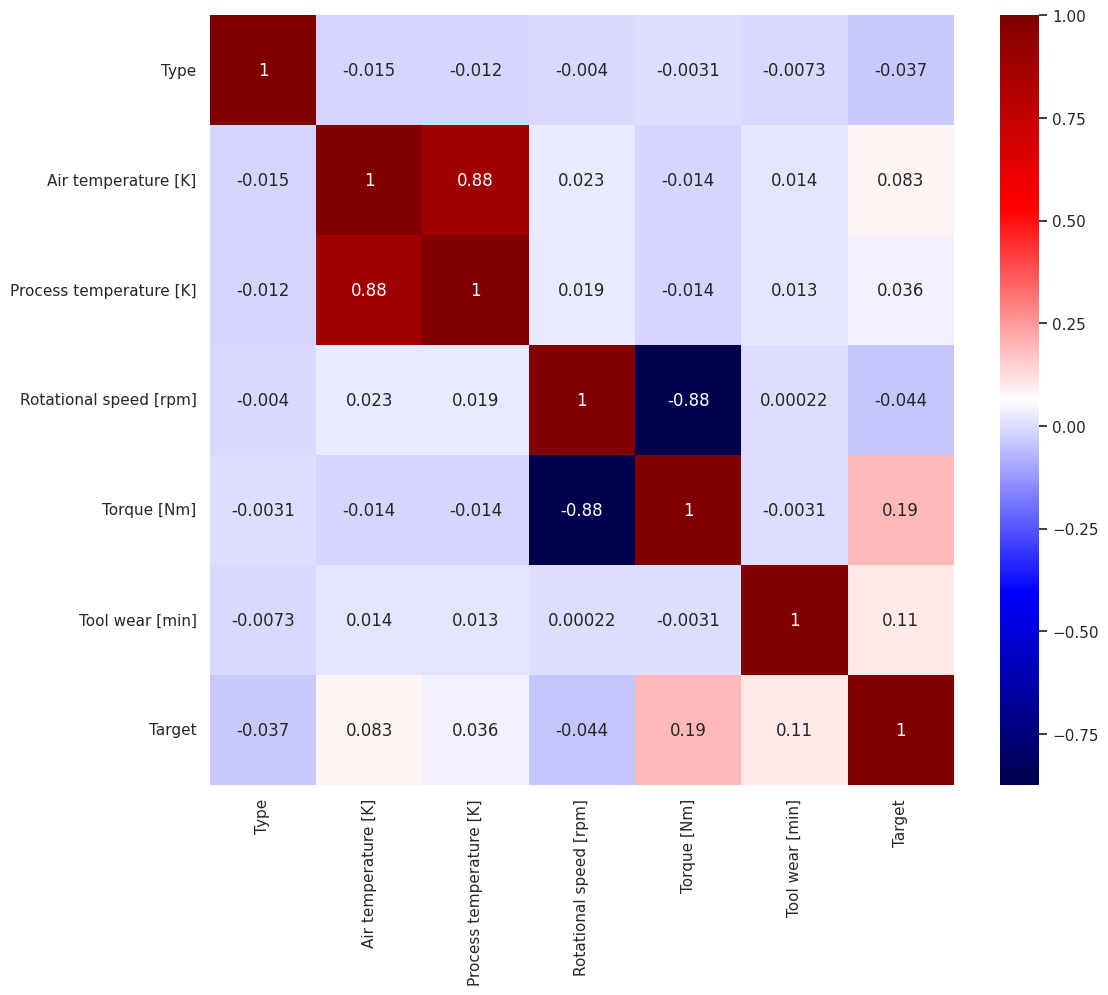

In [217]:
print("Correlation Matrix:")
machining_failure_corrmat = machining_failure_data.copy()
machining_failure_corrmat.drop(id_cols, axis=1, inplace=True)
machining_failure_corrmat.drop('Failure Type', axis=1, inplace=True)

plt.figure(figsize=(12,10))

cor = machining_failure_corrmat.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.seismic)
plt.show()


In [218]:
machining_failure_IVs.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,1,298.1,308.6,1551,42.8,0
1,0,298.2,308.7,1408,46.3,3
2,0,298.1,308.5,1498,49.4,5
3,0,298.2,308.6,1433,39.5,7
4,0,298.2,308.7,1408,40.0,9


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Comparative Box Plots For Each Feature:


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

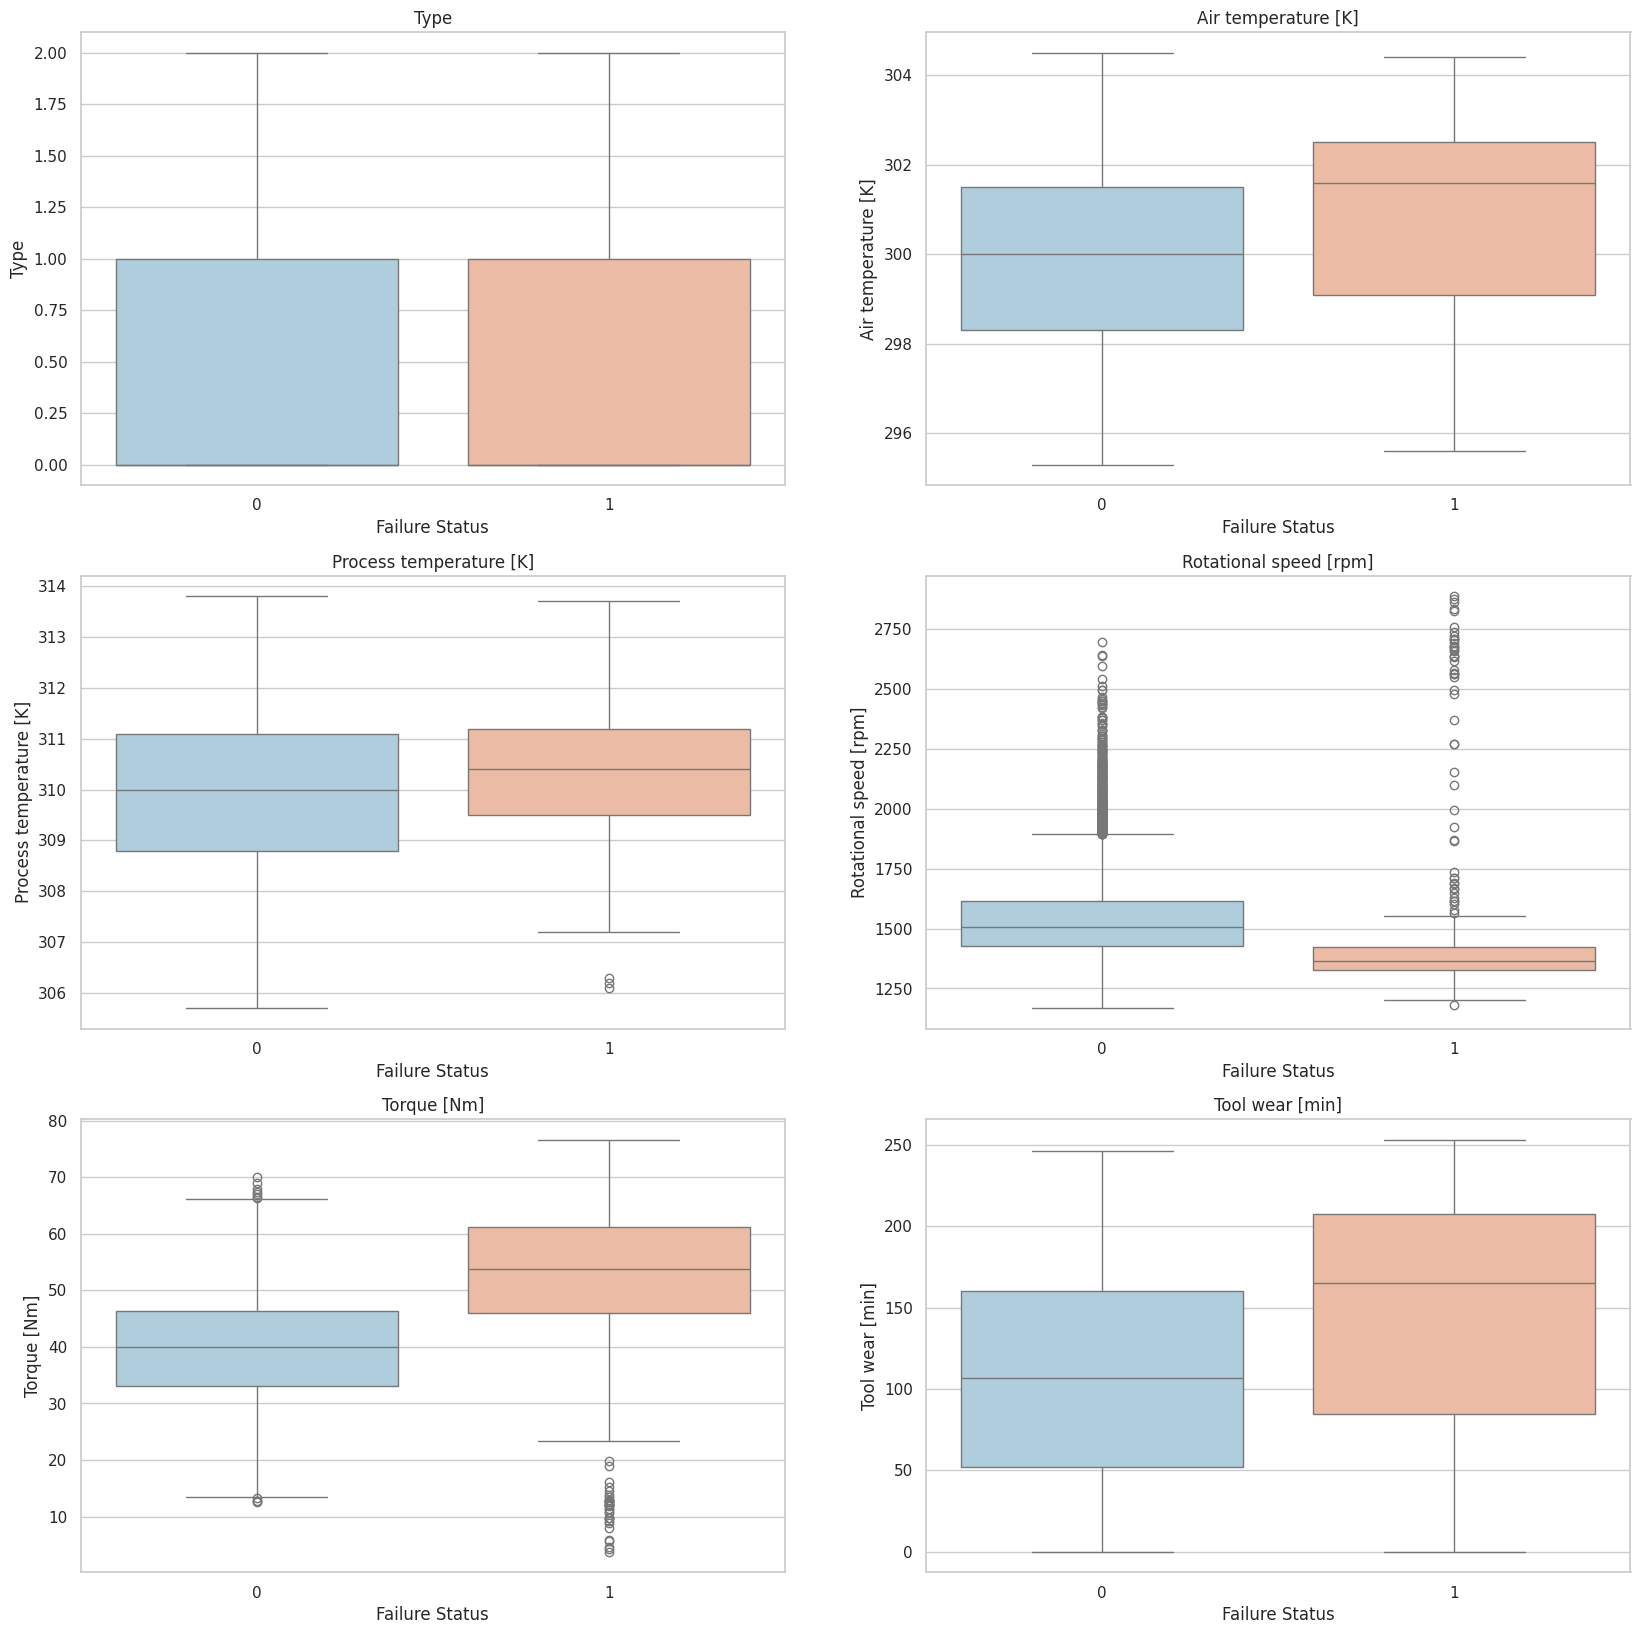

In [219]:
print("Comparative Box Plots For Each Feature:")
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
for i, col in enumerate(machining_failure_IVs.columns):
    sns.boxplot(x=failure_status, y=col, data=machining_failure_IVs, ax=axes[i//2, i%2], palette='RdBu_r')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_xlabel('Failure Status')


Bar Chart of Failure Types:


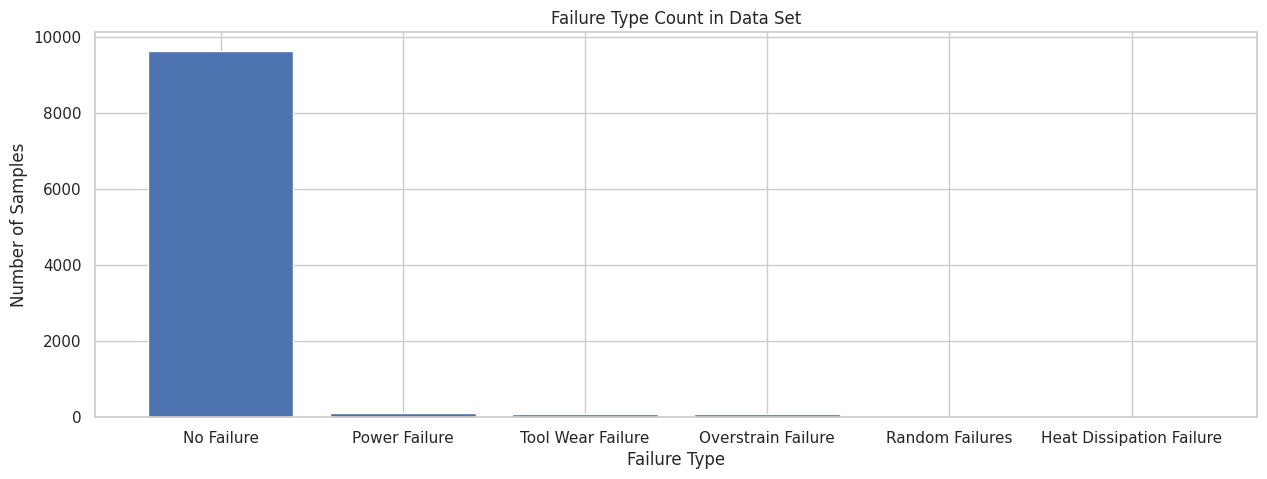

In [220]:
# Create Chart of Failure Type Counts to Visualize Data Imbalance
print("Bar Chart of Failure Types:")
plt.figure(figsize=(15, 5))
plt.bar(failure_types.unique(), failure_types.value_counts())
plt.xlabel('Failure Type')
plt.ylabel('Number of Samples')
plt.title('Failure Type Count in Data Set')
plt.show()

### Plotting Features Over Time


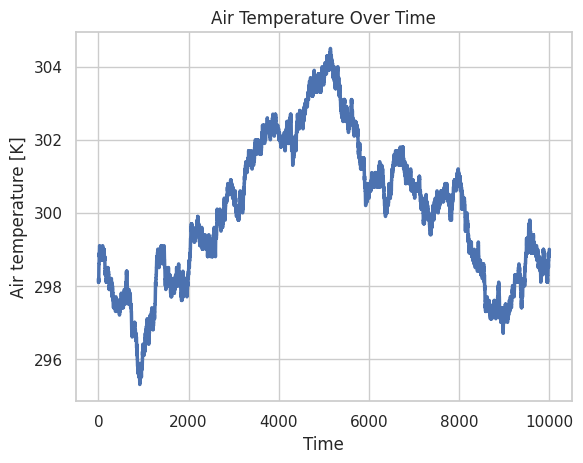

In [221]:
# Plot Room Temperature over Time
sns.set(style="whitegrid")
sns.lineplot(machining_failure_data["Air temperature [K]"], palette='tab10', linewidth=2.5)
plt.xlabel('Time')
plt.title('Air Temperature Over Time')
plt.show()


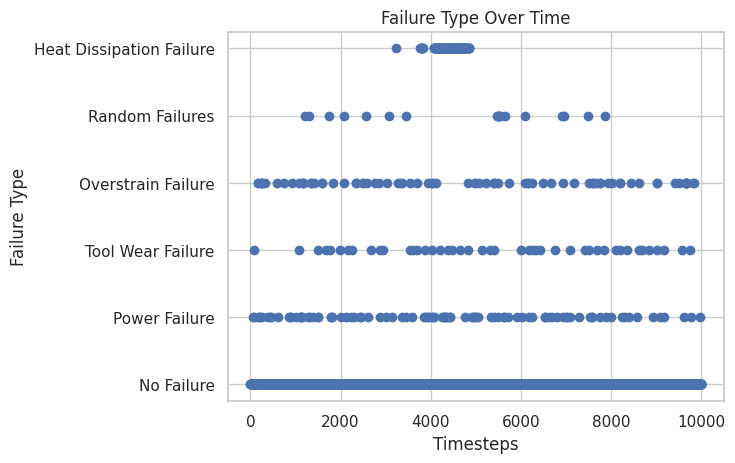

In [222]:
# Plot of the types of failures over time
plt.scatter(machining_failure_data['UDI'],machining_failure_data['Failure Type'])
plt.xlabel('Timesteps')
plt.ylabel('Failure Type')
plt.title('Failure Type Over Time')
plt.show()


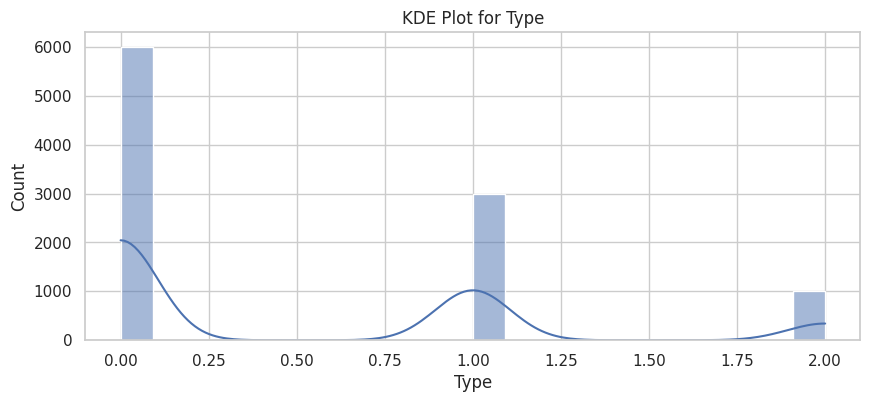

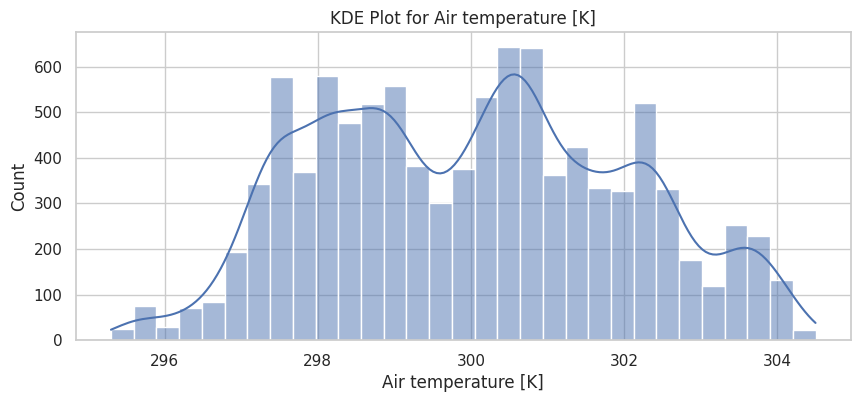

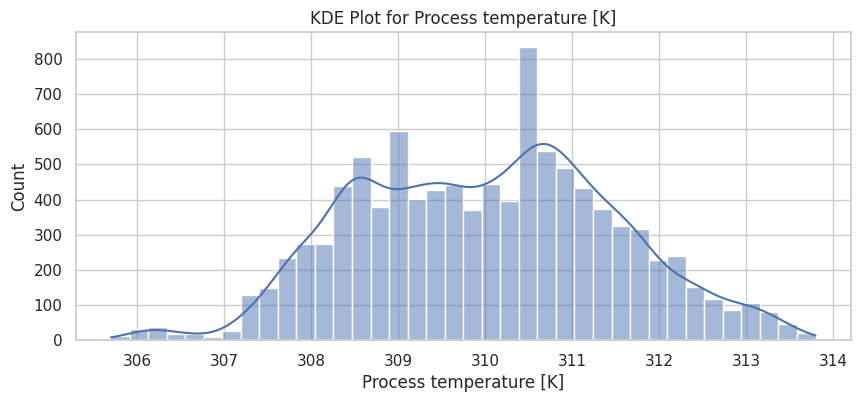

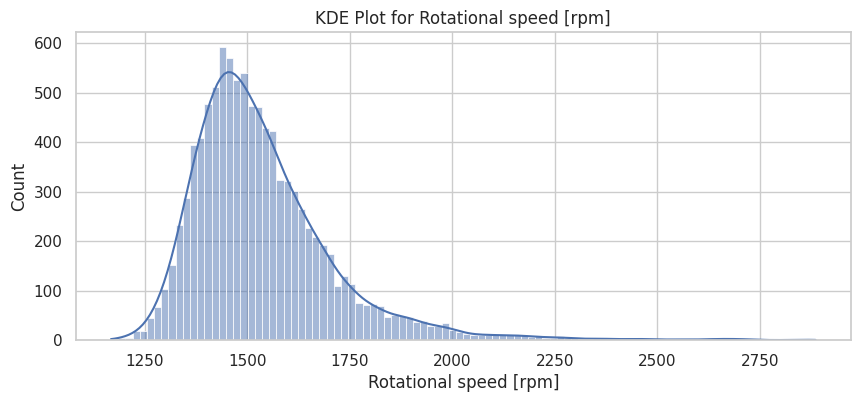

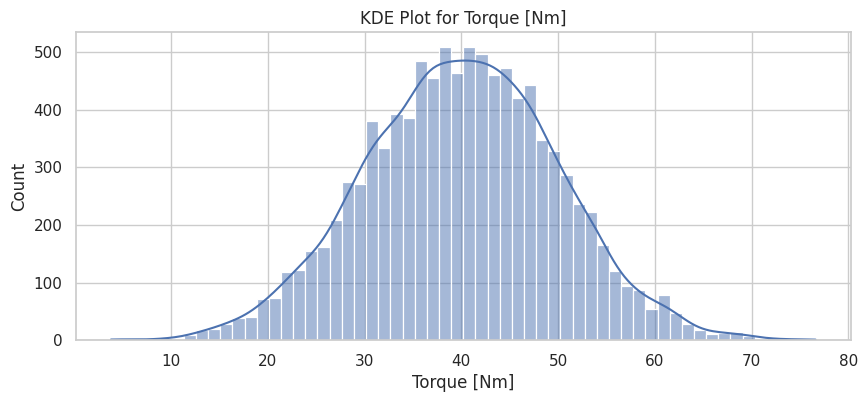

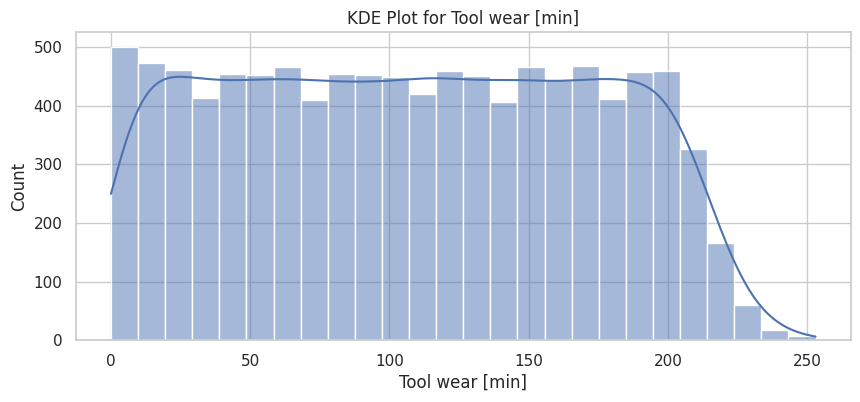

In [223]:
# KDE plots for numeric columns
df_numeric = machining_failure_data.drop(['UDI', 'Product ID', 'Target'], axis=1)
numeric_cols = df_numeric.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(data=df_numeric, x=col, kde=True)
    plt.title(f'KDE Plot for {col}')
    plt.show()

#### Compare Dataframes (Based on Machine Failure)

There are significantly fewer data points with machine failure compared to normal operation, it suggests that machine failures are rare events in the dataset. In datasets where machine failures are infrequent, addressing data imbalance is crucial for effective machine learning. Evaluation metrics beyond accuracy, such as AUC-ROC and F1 score, provide a more nuanced view of model performance. Decision trees and ensemble methods may offer better handling of imbalanced data.

In [224]:
# Comapare dataframes based on machine failure status
df_plot = machining_failure_data.drop(['UDI', 'Product ID', 'Target'], axis=1)
df_final_MF0 = df_plot[df_plot['Failure Type'] == 'No Failure']
df_final_MF1 = df_plot[df_plot['Failure Type'] != 'No Failure']
plot_diff([df_final_MF0, df_final_MF1])

Output hidden; open in https://colab.research.google.com to view.

## Data Preparation

### Feature Engineering

Feature engineering is the process of creating new features from existing features to enhance our understanding of the dataset and possibly improve training and testing.

To train our model, the dataset must be split into a training set and a testing set.

One of the features of the dataset is "Product ID". Product ID is a unique identifier for each entry. If the number of unique Product IDs is less than the total number of entries in the dataset, then there must be multiple entries of the same Product ID. If the number of unique Product IDs is equal to the total number of entries, then all the entries are unique.

In [225]:
# Find total number of entries
print(f"Shape of dataset: {np.shape(machining_failure_data)}")

# Find total number of unique entries in "Product ID"
num_unique_prodIDs = len(machining_failure_data['Product ID'].unique());
print(f"Number of unique product IDs = {num_unique_prodIDs}")

Shape of dataset: (10000, 10)
Number of unique product IDs = 10000


From the code above, we find that the dataset contains 10000 entries as well as 10000 unique Product IDs. Since they are equal, all entries are unique.



### Identifying Pre-Failure

We are interested not only in the ability to detect current failure, but in predicting an upcoming failure before it occurs. An interval of 5 time steps preceding failure will be set as the threshold for pre-failure.

In [226]:
# Addition of Pre-Failure States
prefailure = 0
prefailure_type = ''

# Iterate backwards through the machining_failure_data, set the failure state to rows preceding failure to prefailure-{Failure Type}
for index, row in machining_failure_data[::-1].iterrows():
    if prefailure == 0 and row['Failure Type'] != "No Failure":
        prefailure = 5
        prefailure_type = 'prefailure' + '-' + row['Failure Type']
    elif prefailure > 0:
        machining_failure_data.loc[index,'Failure Type'] = prefailure_type
        prefailure = prefailure - 1

### Feature Selection

Here are the features that will be used as the dependent variables and independent variables. The independent variables will be used to predict the dependent variables.

In [227]:
# The dependent variables
failure_status = machining_failure_data['Target']
failure_types = machining_failure_data['Failure Type']

# The independent variables
machining_failure_IVs = machining_failure_data
machining_failure_IVs = machining_failure_IVs.drop(id_cols, axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Target', axis=1)
machining_failure_IVs = machining_failure_IVs.drop('Failure Type', axis=1)

In [228]:
# Creation of Train Test Split
train_x, test_x, train_y, test_y = train_test_split(machining_failure_IVs, failure_status, test_size=0.4, random_state=32, shuffle=True)

### Addressing Data Imbalance

Data imbalances can negatively impact a model's performance due to some classes being under-represented. Undersampling is the process of deleting samples from the majority class. Oversampling is the process of duplicating samples from the minority class. Both techniques can be used to address data imbalances and create a more balanced dataset.

In [229]:
# initialize undersampler and oversampler
undersampler = RandomUnderSampler(random_state = 32, replacement=False, sampling_strategy=0.4)
oversampler = RandomOverSampler(random_state = 32, sampling_strategy=0.6)

# apply undersampling and oversampling
x_under, y_under = undersampler.fit_resample(train_x, train_y)
x_over, y_over = oversampler.fit_resample(x_under,y_under)

### Handle Categorical Variables

Categorical variables in the dataset were handled through integer encoding which involves converting each category value into a unique integer, making the data more suitable for machine learning algorithmic processing.

The 'Failure Type' variable was encoded as follows:
- 'Heat Dissipation Failure': **0**
- 'No Failure': **1**
- 'Overstrain Failure': **2**
- 'Power Failure': **3**
- 'Random Failures': **4**
- 'Tool Wear Failure': **5**

Similarly, the 'Type' variable was encoded with the following mapping:
- 'H': **0**
- 'L': **1**
- 'M': **2**

In [230]:
# Initialize a LabelEncoder
le = LabelEncoder()

# Fit and transform the 'Failure Type' column
machining_failure_data['Failure Type'] = le.fit_transform(machining_failure_data['Failure Type'])

# Get the mapping of original labels to integer codes for 'Failure Type'
machineFailureType_mapping = dict(zip(le.classes_, range(len(le.classes_))))

print("'Failure Type' integer mapping after encoding: \r\n", machineFailureType_mapping, '\r\n')

# Fit and transform the 'Type' column
machining_failure_data['Type'] = le.fit_transform(machining_failure_data['Type'])

# Get the mapping of original labels to integer codes for 'Type'
type_mapping = dict(zip(le.classes_, range(len(le.classes_))))

print("'Type' integer mapping after encoding: \r\n", type_mapping, '\r\n')

# Print label encoded dataset
print("Label encoded dataset: \r\n", machining_failure_data.head(), '\r\n')

'Failure Type' integer mapping after encoding: 
 {'Heat Dissipation Failure': 0, 'No Failure': 1, 'Overstrain Failure': 2, 'Power Failure': 3, 'Random Failures': 4, 'Tool Wear Failure': 5, 'prefailure-Heat Dissipation Failure': 6, 'prefailure-Overstrain Failure': 7, 'prefailure-Power Failure': 8, 'prefailure-Random Failures': 9, 'prefailure-Tool Wear Failure': 10} 

'Type' integer mapping after encoding: 
 {0: 0, 1: 1, 2: 2} 

Label encoded dataset: 
    UDI Product ID  Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860     1                298.1                    308.6   
1    2     L47181     0                298.2                    308.7   
2    3     L47182     0                298.1                    308.5   
3    4     L47183     0                298.2                    308.6   
4    5     L47184     0                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  Failure Type  
0                    1551

## Modeling - Failure Prediction

We utilize two different models for failure prediction: Long Short-Term Memory (LSTM) and Random Forest.

### Long-Short Term Memory (LSTM)

Long Short-Term Memory networks are recurrent neural networks that are capable of long-term dependencies and are ideal for sequence prediction tasks.

#### Modeling of Prediction of Current Failure or No Current Failure

In [231]:
# Conversion of machining_failure_data to a tensor for use by LSTM model
machining_failure_data_nparray = x_over.values
machining_failure_data_tensor = tf.convert_to_tensor(machining_failure_data_nparray, dtype=tf.float32)

# Creation of LSTM Model
lstm_model = Sequential([
    tf.keras.layers.Dense(32, input_dim=6),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Activation('sigmoid'),
])

# Compile the model
lstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the model
lstm_history = lstm_model.fit(machining_failure_data_tensor, y_over, epochs=100, batch_size=32)

Epoch 1/100
27/27 [==============================] - 2s 7ms/step - loss: 72.0325 - accuracy: 0.6251
Epoch 2/100
27/27 [==============================] - 0s 4ms/step - loss: 8.5449 - accuracy: 0.5711
Epoch 3/100
27/27 [==============================] - 0s 5ms/step - loss: 4.7746 - accuracy: 0.6228
Epoch 4/100
27/27 [==============================] - 0s 4ms/step - loss: 3.7632 - accuracy: 0.6569
Epoch 5/100
27/27 [==============================] - 0s 9ms/step - loss: 3.0309 - accuracy: 0.6428
Epoch 6/100
27/27 [==============================] - 0s 5ms/step - loss: 2.1998 - accuracy: 0.6451
Epoch 7/100
27/27 [==============================] - 0s 5ms/step - loss: 1.6533 - accuracy: 0.5899
Epoch 8/100
27/27 [==============================] - 0s 6ms/step - loss: 1.2259 - accuracy: 0.5640
Epoch 9/100
27/27 [==============================] - 0s 4ms/step - loss: 1.0257 - accuracy: 0.5734
Epoch 10/100
27/27 [==============================] - 0s 6ms/step - loss: 0.9914 - accuracy: 0.5993
Epoch 11

#### Visualize the Model Accuracy and Loss over the Epochs

dict_keys(['loss', 'accuracy'])


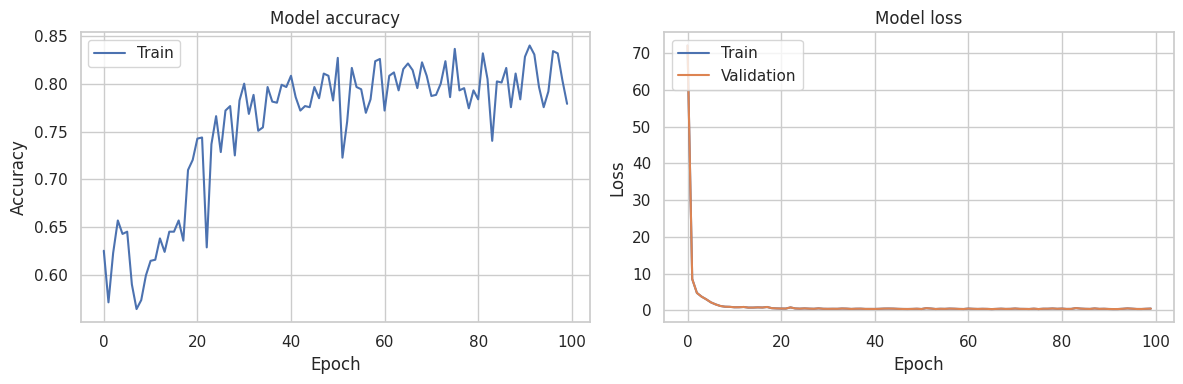

In [232]:
print(lstm_history.history.keys())

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the plot_history function
plot_history(lstm_history)
plt.show()

#### Predictions and Accuracy

In [233]:
predictions = lstm_model.predict(test_x)

predictions = [0 if i < .5 else 1 for i in predictions]
predictions = np.array(predictions)
print('Accuracy:',np.round((accuracy_score(test_y, predictions)*100),2),'%')

#print confusion matrix of results
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print('    0    1')

# print classification report
print("Classification Report:")
print(classification_report(test_y, predictions))


125/125 [==============================] - 0s 2ms/step
Accuracy: 92.22 %
Confusion Matrix:
    0    1
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3874
           1       0.23      0.61      0.33       126

    accuracy                           0.92      4000
   macro avg       0.61      0.77      0.64      4000
weighted avg       0.96      0.92      0.94      4000



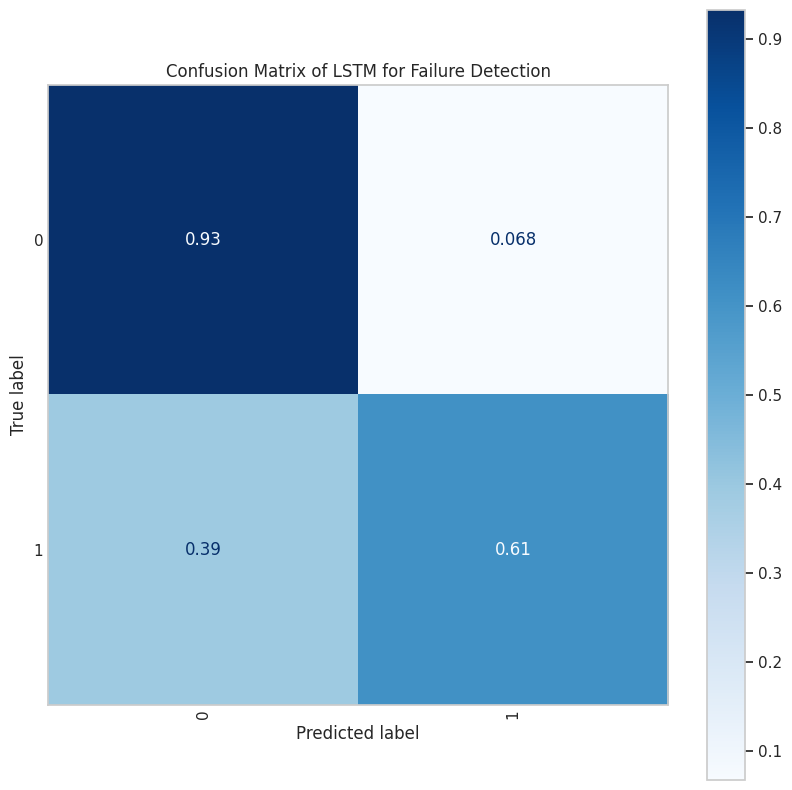

In [234]:
cm = confusion_matrix(test_y, predictions, labels=[0.0,1.0], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['0','1'])


fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap = plt.cm.Blues)
plt.grid(False)
plt.tick_params(axis=u'both', which=u'both',length=0)

plt.title('Confusion Matrix of LSTM for Failure Detection')
plt.show()

### Random Forest

The initial Random Forest Classifier achieved a training accuracy of 1.0 and test accuracy of 0.98275, suggesting high performance. However, to address potential overfitting, hyperparameter tuning was conducted, resulting in optimal parameters of a max depth of 14 and 55 estimators. Post-tuning, a slight decrease in accuracy was observed (training: 0.9965, test: 0.9825), which may indicate improved generalization capabilities for new, unseen data.

#### Model Creation

In [235]:
# Building the Random Forest
rf = RandomForestClassifier(random_state=0) # Create Random Forest classifer object
rf = rf.fit(train_x, train_y) # Train Random Forest Classifer

In [236]:
# Evaluating the RF model
rf_y_hat = rf.predict(train_x) # Predict the response for train dataset
rf_y_pred = rf.predict(test_x) # Predict the response for test dataset

# Compute training and test accuracy
print("Train Accuracy:", metrics.accuracy_score(train_y, rf_y_hat))
print("Test Accuracy:", metrics.accuracy_score(test_y, rf_y_pred))

Train Accuracy: 1.0
Test Accuracy: 0.98275


In [237]:
# Hyperparameter search
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)} # Search ranges
rand_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5) # Use random search to find the best hyperparameters
rand_search.fit(train_x, train_y) # Fit the random search object to the training data

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

best_rf = rand_search.best_estimator_ # Capture the best model
best_rf_y_hat = best_rf.predict(train_x) # Predict the response for train dataset
best_rf_y_pred = best_rf.predict(test_x) # Predict the response for test dataset

# Compute training and test accuracy
print("Train Accuracy:", metrics.accuracy_score(train_y, best_rf_y_hat))
print("Test Accuracy:", metrics.accuracy_score(test_y, best_rf_y_pred))

Best hyperparameters: {'max_depth': 17, 'n_estimators': 341}
Train Accuracy: 1.0
Test Accuracy: 0.98325


#### Model Evaluation

Random Forest Classification Report:
Accuracy: 0.98275
Precision: 0.9815037638965922
Recall: 0.98275
F1-Score: 0.98051148770387
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3874
           1       0.89      0.52      0.65       126

    accuracy                           0.98      4000
   macro avg       0.94      0.76      0.82      4000
weighted avg       0.98      0.98      0.98      4000



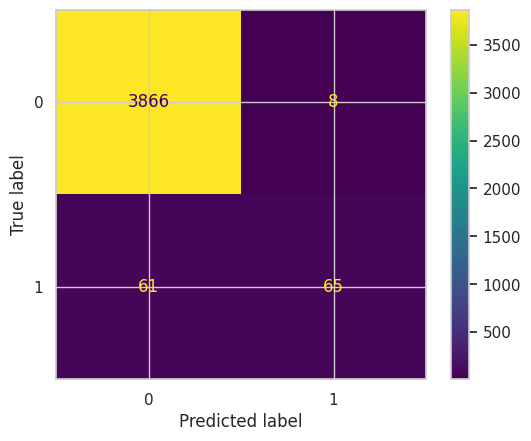

In [238]:
# Random Forest
# Calculate predicted probabilities for each class
rf_probs = rf.predict_proba(test_x)
print('Random Forest Classification Report:')
print("Accuracy:", metrics.accuracy_score(test_y, rf_y_pred))
print("Precision:", metrics.precision_score(test_y, rf_y_pred, average = 'weighted'))
print("Recall:", metrics.recall_score(test_y, rf_y_pred, average = 'weighted'))
print("F1-Score:", metrics.f1_score(test_y, rf_y_pred, average = 'weighted'))
print(metrics.classification_report(test_y, rf_y_pred))

# Create the confusion matrix
cm = metrics.confusion_matrix(test_y, rf_y_pred)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Discussion and Conclusions

The primary objective of this project was to create a predictive model capable of precisely predicting the probability and nature of potential future machine failures. The models were trained on an extensive Predictive Maintenance Dataset that encompasses temperature metrics, machine measurement readings, variations in product quality, states of failure, and types of failure.

The models used in this project included a Long Short-Term Memory model and Random Forest Classifier. Each of these models showed high performance, with almost perfect scores in the Random Forest Classifier. After adjustments in hyperparameters and the use of cross-validation, the models generalized better without memorizing the training data.

## Recommendations

Based on the results of this project, it is recommended to use ensemble methods like Random Forest for predictive maintenance as they showed high performance and good generalization to unseen data. However, it’s important to consider other factors such as the complexity of the models, the interpretability of the results, and the computational resources required for training and prediction.

Furthermore, it’s crucial to continue exploring other modeling techniques and hyperparameter optimization strategies to improve the predictive performance. Regular retraining of the models with the most recent data can also help maintain their predictive power.

Ultimately, the success of this project could transform maintenance practices in machinery production, steering towards more durable, efficient, and economical operations. The predictive models developed in this project can facilitate preemptive maintenance approaches, prolong the equipment’s operational life, and offer considerable financial benefits to consumers. This aligns with the project’s primary objective and justification.

In conclusion, the project has successfully demonstrated the power of machine learning in predictive maintenance, providing valuable insights for future work in this area.